<a href="https://colab.research.google.com/github/agpascoe/NN_experiments/blob/main/Pytorch/Desease_BiClass_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Predicting Heart Desease w/pytorch classes implementation
## Sept 2022

This is a Bi Classification Model, where we need to predict if a pascient with some caharacteristics, might be a heart desease (1) or not.

Nevertheless this is a typical NN problem, the key value of this implementation is in the class encapsulation (the whole model in modeled as a class), the split function, and finally the experiment that runs a bunch of parmeters.

In [6]:
# Note: this code uses some lines and ideas from DUDL_metaparams_multioutput.ipynb (section "Metaparameters")

In [7]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Download and inspect the data

In [8]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


#data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

data.head(5)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


#Data Dictionary:
##3 age: age in years
##4 sex: sex (1 = male; 0 = female)
##9 cp: chest pain type
###-- Value 1: typical angina
###-- Value 2: atypical angina
###-- Value 3: non-anginal pain
###-- Value 4: asymptomatic
##10 trestbps: resting blood pressure (in mm Hg on admission to the hospital)
##12 chol: serum cholestoral in mg/dl
##16 fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
##19 restecg: resting electrocardiographic results
###-- Value 0: normal
###-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
###-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
##32 thalach: maximum heart rate achieved
##38 exang: exercise induced angina (1 = yes; 0 = no)
##40 oldpeak = ST depression induced by exercise relative to rest
##41 slope: the slope of the peak exercise ST segment
###-- Value 1: upsloping
###-- Value 2: flat
###-- Value 3: downsloping
###44 ca: number of major vessels (0-3) colored by flourosopy


In [9]:
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
DISEASE       int64
dtype: object

In [10]:
#Needed to convert some datatypes to float

data["ca"] = data["ca"].astype("float64")
data["thal"] = data["thal"].astype("float64")
data.dtypes


age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
DISEASE       int64
dtype: object

In [11]:
#lets convert the dataframe into a matrix x

x = np.array(data.loc[:,"age":"thal"]).astype("float64")
print(x[:5],x.shape)
xNum = x.shape[1]


[[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
    6. ]
 [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
    3. ]
 [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
    7. ]
 [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
    3. ]
 [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
    3. ]] (297, 13)


In [12]:
#here we eliminate the disbalance in desease, an just leave 2 cases 0 or 1.

data[data['DISEASE']>0] = 1 #comment if want 5 not 1 different result

In [13]:
#here we get the labels vector
labelsNum = data['DISEASE'].unique().shape[0]
labels = np.array(data["DISEASE"])
print(labels[:5],labels.shape, labelsNum)



[0 1 1 0 0] (297,) 2


In [14]:
#this is the split function for getting datasets of trainnig, validation and testing according with partitions array.

def splitData(partitions, batch_size, data, labels, verbose=False):

  # partitions =[%trainning, %test]
  # split the data
  data = torch.tensor(data).float()
  labels = torch.tensor(labels).long()

  train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0],shuffle=True)#randomized

  # now split the devtest data
  dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1]/(1-partitions[0]),shuffle=True)
  
  # print out the sizes
  if verbose:
    print('   Total data size: ' + str(data.shape) + '\n')
    print('Training data size: ' + str(train_data.shape))
    print('Trainning Label data size: ' + str(train_labels.shape))
    print('Dev data size: ' + str(dev_data.shape))
    print('Dev Label data size: ' + str(dev_labels.shape))
    print('Dev test size: ' + str(test_data.shape))
    print('Dev test data size: ' + str(test_labels.shape))

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data, train_labels)
  dev_data   = TensorDataset(dev_data,dev_labels)
  test_data  = TensorDataset(test_data,test_labels)
 
 
  # finally, translate into dataloader objects
  train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
  dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return(train_loader, dev_loader, test_loader)



# Create and validate the model

In [15]:
class binaryRegNet(nn.Module):
    def __init__(self, nImputs, nOutputs, hidden, nHidden, dr=0.0):
      super().__init__()
      #Create a dictionary to save the layers
      self.layers = nn.ModuleDict()
      self.nHidden = nHidden
      self.hidden = hidden
      self.dr = dr #Dropuot rate
      
      ### input layer
      self.layers["input"] = nn.Linear(nImputs,nHidden)

      for h in range(self.hidden):      
      ### hidden layer
        self.layers[f'hidden{h}'] = nn.Linear(nHidden,nHidden)

      ### output layer
      self.layers['output'] = nn.Linear(nHidden,nOutputs)



    # forward pass
    def forward(self,x):
      x = F.relu( self.layers['input'](x) )
      x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
      for h in range(self.hidden):
        x = F.relu( self.layers[f'hidden{h}'](x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
      return self.layers['output'](x)

    def testModel(self, n, test_loader):
      # extract X,y from test dataloader
      X,y = next(iter(test_loader)) 
      self.load_state_dict(n['net'])
      yHat = self.forward(X)
      bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      return(yHat, bestAcc)


    def fit(self, train_loader, dev_loader, numepochs = 100, learningRate=0.01, weight_decay=0.1, draw=True):
      # New! initialize a dictionary for the best model
      theBestModel = {'Accuracy':0, 'net':None, 'epoch':0} #net will be the whole model instance

      # loss function
      self.lossfun = nn.CrossEntropyLoss()

      # optimizer
      self.optimizer = torch.optim.Adam(self.parameters(), learningRate, weight_decay=weight_decay, )


      # initialize losses
      losses   = torch.zeros(numepochs)
      trainAcc = []
      devAcc   = []

      # loop over epochs
      for epochi in range(numepochs):

        # switch on training mode
        self.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
          yHat = self.forward(X)
          loss = self.lossfun(yHat,y)

          # backprop
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # loss from this batch
          batchLoss.append(loss.item())

          # compute accuracy
          matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
          matchesNumeric = matches.float()             # convert to numbers (0/1)
          accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
          batchAcc.append( accuracyPct )               # add to list of accuracies
          # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        self.eval()
        X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
        with torch.no_grad(): # deactivates autograd
          yHat = self.forward(X)
      
        # compare the following really long line of code to the training accuracy lines
        devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


        # New! Store this model if it's the best so far
        if devAcc[-1]>theBestModel['Accuracy']:
      
          # new best accuracy
          theBestModel['Accuracy'] = devAcc[-1].item()
      
          # epoch iteration
          theBestModel['epoch'] = epochi

          # model's internal state
          theBestModel['net'] = copy.deepcopy( self.state_dict() ) #here update the best model
      
        # end epochs
      if(draw):
        #plot results of trainning
        fig,ax = plt.subplots(1,2,figsize=(16,5))
        ax[0].plot(losses.detach(),'o-')
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_title('Losses')

        ax[1].plot(trainAcc,'o-',label='Train')
        ax[1].plot(devAcc,'o-',label='Devset')
        ax[1].set_ylabel('Accuracy (%)')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Accuracy')
        #ax[1].set_ylim([85,95])
        #ax[1].set_xlim([80,105])
        ax[1].legend()
        plt.show()

      # function output
      return trainAcc,devAcc,losses,theBestModel


# Run the model and plot the results

In [16]:

# run the model
#We will run this experiment, using three variables, number of HIDDEN layers, number of node on each one of those hidden (NHIDDEN)
# and a repeater to validate results consistency beacuse as you might se, we are not using random_seed
# this experiment also has two key characteristics that you can replicate in yours:
# ->it shows for each run or experiment, wher the model got the best performance(epch-accuracy) and with which set of params
# ->you can adjust a lot of params for regularization, architecture and speed 


HIDDEN = [1,2,3,4]
NHIDDEN = [8, 16, 32, 64]
score={'HL':[],
    'Hn':[],
    'TestAcc':[]}

train_loader, dev_loader, test_loader = splitData([0.745,0.135], 10, x, labels, verbose=True )

for i in range(10):
  Bench = 0.0  
  print('\n *** set: ', i, 'cambio de conjunto de sets para trainning/dev/test')   
  
  for h in HIDDEN:
    for nh in NHIDDEN:
      n = binaryRegNet(nImputs=xNum, nOutputs=labelsNum, hidden=h, nHidden=nh, dr=0)
      trainAcc,devAcc,losses,theBestModel = n.fit(train_loader=train_loader, dev_loader=dev_loader, numepochs=75, learningRate=0.0001, weight_decay=0.1, draw=False)
      yHat, bestAcc = n.testModel(theBestModel, test_loader)
      if (Bench <= bestAcc.float() and theBestModel['epoch']>10):
        print(f"Hidden Layers:{h},  Nodes in HL:{nh}, Best_DevAcc: {theBestModel['Accuracy']:.2f}, BestModel_test: {bestAcc.float():.2f}, en step: {theBestModel['epoch']:.2f}")
        Bench = bestAcc.float()
        score['HL'].append(h)
        score['Hn'].append(nh)
        score['TestAcc'].append(bestAcc.float())

  train_loader, dev_loader, test_loader = splitData([0.745,0.135], 10, x, labels, verbose=False )

score = pd.DataFrame(score)
score[(score['HL']!=1) & (score['Hn']!=8)].sort_values(['TestAcc'], ascending=False)

   Total data size: torch.Size([297, 13])

Training data size: torch.Size([221, 13])
Trainning Label data size: torch.Size([221])
Dev data size: torch.Size([40, 13])
Dev Label data size: torch.Size([40])
Dev test size: torch.Size([36, 13])
Dev test data size: torch.Size([36])

 *** set:  0 cambio de conjunto de sets para trainning/dev/test
Hidden Layers:1,  Nodes in HL:8, Best_DevAcc: 75.00, BestModel_test: 69.44, en step: 15.00
Hidden Layers:2,  Nodes in HL:16, Best_DevAcc: 65.00, BestModel_test: 80.56, en step: 27.00
Hidden Layers:3,  Nodes in HL:8, Best_DevAcc: 65.00, BestModel_test: 80.56, en step: 42.00

 *** set:  1 cambio de conjunto de sets para trainning/dev/test
Hidden Layers:1,  Nodes in HL:8, Best_DevAcc: 77.50, BestModel_test: 69.44, en step: 57.00
Hidden Layers:1,  Nodes in HL:64, Best_DevAcc: 82.50, BestModel_test: 77.78, en step: 64.00

 *** set:  2 cambio de conjunto de sets para trainning/dev/test
Hidden Layers:1,  Nodes in HL:8, Best_DevAcc: 67.50, BestModel_test: 72

,HL,Hn,TestAcc
27,3,32,tensor(83.3333)
1,2,16,tensor(80.5556)
26,2,32,tensor(80.5556)
16,2,64,tensor(75.)
30,2,64,tensor(69.4444)
19,2,16,tensor(66.6667)
20,3,16,tensor(66.6667)
21,3,64,tensor(66.6667)


In [17]:
print('Accuracy Devset:', theBestModel['Accuracy'])
yHat, bestAcc = n.testModel(theBestModel, test_loader)
print('Accuracy Test:', float(bestAcc))
print('On iteration: ', theBestModel['epoch'])


Accuracy Devset: 65.0
Accuracy Test: 61.11111068725586
On iteration:  2


In [18]:
print(torch.exp(yHat[:5]),test_loader.dataset.tensors[1][:5])

tensor([[0.3908, 0.3310],
        [0.3197, 0.3674],
        [0.3878, 0.3304],
        [0.3002, 0.3433],
        [0.4458, 0.3069]], grad_fn=<ExpBackward0>) tensor([1, 1, 1, 1, 0])


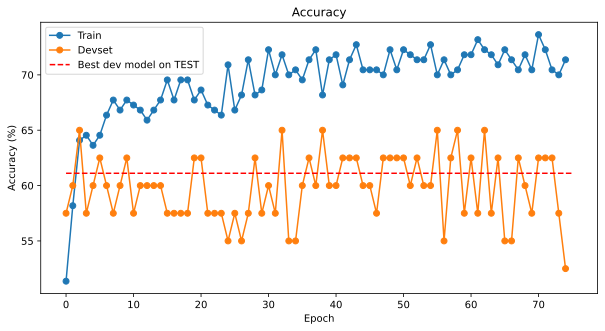

In [19]:

fig = plt.figure(figsize=(10,5))
plt.plot(trainAcc,'o-',label='Train')
plt.plot(devAcc,'o-',label='Devset')
plt.plot([0,len(devAcc)],[bestAcc,bestAcc],'r--',label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
#plt.ylim([bestAcc-5,bestAcc+5])
plt.legend()
plt.show()